In [1]:
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
from typing import Set, List, Dict
import json

In [2]:
validated_data = pd.read_csv('./cv-corpus-20.0-2024-12-06/th/validated.tsv', sep='\t')

/var/folders/cm/lb23lq6s6f319w__2lgw1zfm0000gn/T/ipykernel_57448/1077912770.py:1: DtypeWarning: Columns (9,12) have mixed types. Specify dtype option on import or set low_memory=False.
  validated_data = pd.read_csv('./cv-corpus-20.0-2024-12-06/th/validated.tsv', sep='\t')


In [3]:
client_id_counts = validated_data['client_id'].value_counts()
filtered = client_id_counts[client_id_counts >= 100]
filtered_counts = filtered.to_list()
filtered_counts.sort()
print("Number of clients who have more than 100 data entries:",len(filtered_counts))

Number of clients who have more than 100 data entries: 134


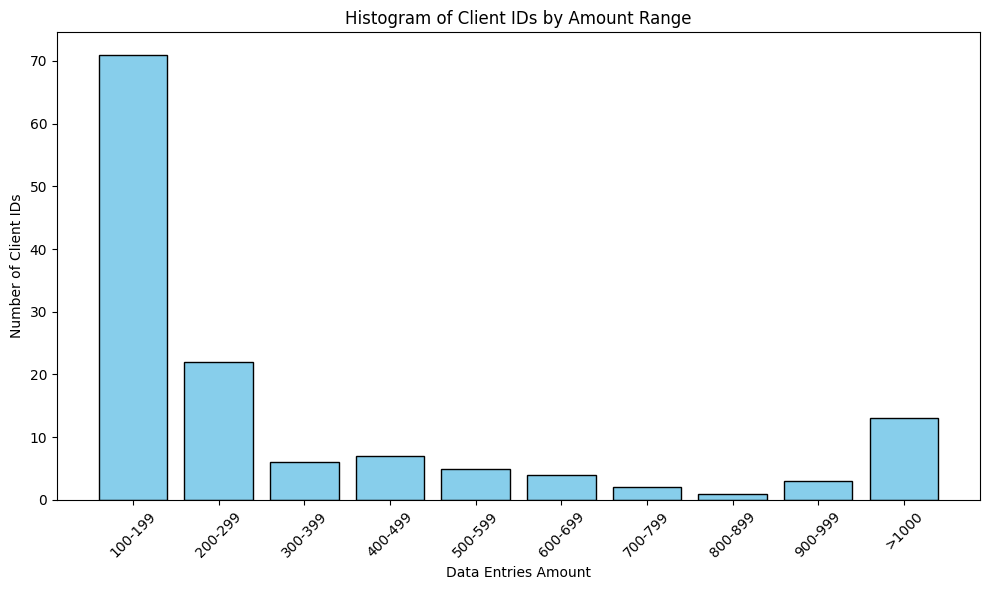

In [4]:
# Define the bins
bins = list(range(100, 1100, 100)) + [float('inf')]
bin_labels = [f'{i}-{i+99}' for i in range(100, 1000, 100)] + ['>1000']

# Categorize the amounts into bins
hist_data = [0] * len(bin_labels)

for amount in filtered_counts:
    for i, upper in enumerate(bins):
        if amount < upper:
            hist_data[i-1] += 1
            break

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(bin_labels, hist_data, width=0.8, color='skyblue', edgecolor='black')
plt.xlabel('Data Entries Amount')
plt.ylabel('Number of Client IDs')
plt.title('Histogram of Client IDs by Amount Range')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
def replace_words(dataframe: pd.DataFrame, column_name: str, replacing_pairs: List[List[str]]) -> pd.DataFrame:
    for old_word, new_word in replacing_pairs:
        dataframe[column_name] = dataframe[column_name].apply(lambda x: x.replace(old_word, new_word))
    return dataframe

In [6]:
replacing_word = [
    ['เพฃร', 'เพชร'],
    ]

filtered_data = validated_data[validated_data['client_id'].isin(filtered.keys())]
filtered_data = replace_words(filtered_data, 'sentence', replacing_word)
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92956 entries, 55101 to 148056
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   client_id        92956 non-null  object 
 1   path             92956 non-null  object 
 2   sentence_id      92956 non-null  object 
 3   sentence         92956 non-null  object 
 4   sentence_domain  0 non-null      float64
 5   up_votes         92956 non-null  int64  
 6   down_votes       92956 non-null  int64  
 7   age              75533 non-null  object 
 8   gender           74532 non-null  object 
 9   accents          2881 non-null   object 
 10  variant          0 non-null      float64
 11  locale           92956 non-null  object 
 12  segment          28 non-null     object 
dtypes: float64(2), int64(2), object(9)
memory usage: 9.9+ MB


/var/folders/cm/lb23lq6s6f319w__2lgw1zfm0000gn/T/ipykernel_57448/3998092966.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[column_name] = dataframe[column_name].apply(lambda x: x.replace(old_word, new_word))


In [7]:
class Data:
    def __init__(self, sentence:str, path:str):
        self.sentence = sentence
        self.path = path

In [8]:
# Group by 'client_id' and aggregate both 'sentence' and 'path' into lists
grouped = filtered_data.groupby('client_id').agg(list)

In [9]:
id_mapper: Dict[str, str] = dict()

for index, client_id in enumerate(filtered.keys()):
    id_mapper[client_id] = f'cv{str(index + 1).zfill(3)}'
    
# Construct the dictionary with Data objects
grouped_data = {
    f'{id_mapper[client_id]}': [Data(sentence, path) for sentence, path in zip(sentences, paths)]
    for (client_id, (sentences, paths)) in grouped[['sentence', 'path']].iterrows()
}

In [10]:
# Define paths
FILE_PATH = "vctk-struc"
TEXT_PATH = "vctk-struc/txt"  # txt/{client_id}/{client_id}_{index_3_digit}.txt
MP3_PATH = "vctk-struc/wav48_silence_trimmed"  # wav48_silence_trimmed/{client_id}/{client_id}_{index_3_digit}.mp3

OLD_MP3_PATH = "cv-corpus-20.0-2024-12-06/th/clips"

all_chars: Set[str] = set()

# Clean up the existing FILE_PATH if it exists
if os.path.exists(FILE_PATH):
    shutil.rmtree(FILE_PATH)

# Create the required directories
os.makedirs(TEXT_PATH, exist_ok=True)
os.makedirs(MP3_PATH, exist_ok=True)

# Iterate over grouped data and copy text and MP3 files
for client_id, data in grouped_data.items():
    client_id_text_path = os.path.join(TEXT_PATH, client_id)
    os.makedirs(client_id_text_path, exist_ok=True)

    # Iterate over data to write sentences and copy MP3 files
    for i, d in enumerate(data):
        # Writing sentence to a text file
        with open(os.path.join(client_id_text_path, f"{client_id}_{(i + 1):03d}.txt"), 'w') as f:
            f.write(d.sentence)
            all_chars.update(list(d.sentence))

        # Ensure the MP3 directory for this client exists
        client_mp3_path = os.path.join(MP3_PATH, client_id)
        os.makedirs(client_mp3_path, exist_ok=True)

        # Copy the corresponding MP3 file from the original path
        shutil.copyfile(
            os.path.join(OLD_MP3_PATH, d.path),
            os.path.join(client_mp3_path, f"{client_id}_{i:03d}.mp3")
        )

print("Restructuring done")

Restructuring done


In [11]:
# grouped_data -> {client_id:string,
# data: {
    # path: string,
    # sentence: string
    # }[]
# }[]
with open(f"{FILE_PATH}/grouped_data.json", "w") as f:
    json.dump(
        [{ "client_id": client_id, "data": [{"path": d.path, "sentence": d.sentence} for d in data ]} for client_id, data in grouped_data.items()],
        f,
        indent = 2
    )

with open(f"{FILE_PATH}/language_ids.json", "w") as f:
    json.dump(
        { 'th': 0},
        f,
        indent = 2
    )

with open(f"{FILE_PATH}/speakers_ids.json", "w") as f:
    json.dump({client_id : i for i, client_id in enumerate(grouped_data.keys())}, f, indent = 2)
    
with open(f"{FILE_PATH}/all_chars_uni.txt", "w") as f:
    unicode_data = "".join([c.encode('unicode_escape').decode('ascii') for c in sorted(all_chars)])
    f.write(unicode_data)
    
with open(f"{FILE_PATH}/all_chars.txt", "w") as f:
    unicode_data = "".join(sorted(all_chars))
    f.write(unicode_data)
    
with open(f"{FILE_PATH}/id_mapper.json", "w") as f:
    json.dump(id_mapper, f, indent = 2)